# 06. Consideraciones sobre el cómputo aproximado de la distancia muestral de fermat, $D_{Q,\alpha}$

### Análisis
- Las aproximaciones que provee `fermat.Fermat` (métodos "Landmarks" y "Djikstra") están bastante rotas:
  - cuando $k=N$ no dan iguales que "Floyd Warshall", aunque deberían, y
  - a veces, cuando aumenta $k$ para una muestra $Q$ fija, los caminos mínimos _aumentan_ en lugar de mantenerse iguales o disminuir.
- El grafo de Delaunay es impracticablemente caro de computar para cualquier dataset de tamaño razonable
- La aproximación de distancias de Fermat sobre el grafo de $\log n$ vecinos más cercanos acorta los tiempos a $1/2 - 1/3$, pero constantemente sobreestima la distancia en un 50%, con muchísima variación alrededor. El factor de inflación no parece disminuir cuando $n$ crece, con lo cual la situación no mejora "asintóticamente".

### Conclusiones
Visto y considerando, por el momento:
- No consideraremos ninguna aproximación a $D_{Q,\alpha}$: la camcularemos con el grafo completo de la muestra, o a lo sumo con una muestra elegida por SRS limitada a `N=max_n` razonable para controlar los tiempos de cómputo.
- Quitaremos las dependencias de `fermat.Fermat`, ya que el cómputo con FW sobre el grafo completo se puede escribir muy sencillamente con `scipy` "crudo".

In [63]:
import numpy as np
import pandas as pd

# import scipy as sp
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import (
    load_iris,
    load_digits,
    make_moons,
    fetch_openml,
    make_circles,
)
from scipy.spatial.distance import cdist, pdist, squareform

from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix
from numbers import Number


def euclidean(X, Y=None):
    if Y is None:
        return squareform(pdist(X, metric="euclidean"))
    else:
        return cdist(X, Y, metric="euclidean")

In [64]:
# X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
# X, y = make_moons(n_samples=10000, noise=0.1)
# X, y = load_digits(return_X_y=True)
X, y = fetch_openml('mnist_784', version=1, parser="auto", return_X_y=True, as_frame=False)

In [65]:
X.shape, np.unique(y)

((70000, 784),
 array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object))

In [66]:
y = y.astype(int)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [67]:
pd.Series(y).value_counts()

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

In [68]:
X = X[y == 0]
X.shape

(6903, 784)

[[  0   0   0   0   0]
 [  0   0   0   7 135]
 [  0   0   7 131 252]
 [  0  48 165 252 173]
 [114 238 253 162   0]]


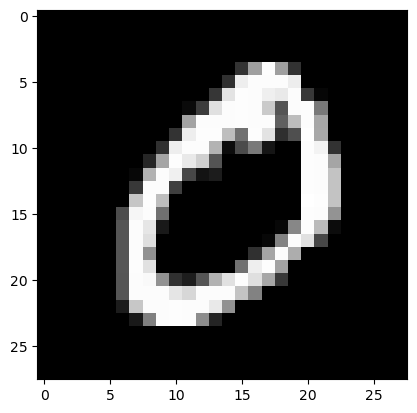

In [69]:
pixels = X[0].reshape(28, 28)
print(pixels[15:20, 15:20])
plt.imshow(pixels, cmap="gray")

In [70]:
alpha = 1 + 2 * np.random.rand()

In [71]:
from time import time

dists = euclidean(X)

In [72]:
from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path


def kNN_sample_fermat(Q, alpha, k):
    N = Q.shape[0]
    tree = KDTree(Q, metric="euclidean")
    nearest_distances, nearest_indices = tree.query(Q, k=k + 1)
    indptr = np.arange(0, N * (k + 1) + 1, k + 1)
    indices = nearest_indices.flatten()
    data = nearest_distances.flatten()
    kNN = csr_matrix((data**alpha, indices, indptr))
    return shortest_path(csgraph=kNN, directed=False)

In [73]:
import networkx as nx

def sample_fermat(Q, alpha=1, method="fermat"):
    dists = euclidean(Q)
    if method == "fw":
        return Fermat(alpha=alpha, path_method="FW").fit(dists).get_distances()
    elif method == "networkx":
        G = nx.from_numpy_matrix(dists**alpha)
        return nx.floyd_warshall_numpy(G)
    elif method == "scipy_matrix":
        return shortest_path(csr_matrix(dists**alpha), directed=False)
    elif method == "scipy_array":
        return shortest_path(
            csgraph=np.power(dists, alpha), method="FW", directed=False
        )
    else:
        raise ValueError("Invalid method")

In [74]:
(
    Fermat(alpha=alpha, path_method="D", k=6).fit(dists[:10, :10]).get_distances()
    - Fermat(alpha=alpha, path_method="D", k=5).fit(dists[:10, :10]).get_distances()
).round(2)

array([[       0.  ,        0.  ,        0.  ,        0.  ,  2098635.75,
               0.  ,  2436793.11,        0.  , -1349223.52,  2333293.  ],
       [       0.  ,        0.  , -2015503.12,   -89855.32,        0.  ,
               0.  ,   314283.78,        0.  ,        0.  ,        0.  ],
       [       0.  , -2015503.12,        0.  ,        0.  ,   317789.88,
               0.  ,  2436793.11,        0.  ,  -554375.68,   317789.88],
       [       0.  ,   -89855.32,        0.  ,        0.  ,        0.  ,
         -478867.04,  1957926.07, -3106094.64,        0.  ,        0.  ],
       [ 2098635.75,        0.  ,   317789.88,        0.  ,        0.  ,
         2996380.04,   127599.54,   341161.63,  1468883.08,        0.  ],
       [       0.  ,        0.  ,        0.  ,  -478867.04,  2996380.04,
               0.  ,  -980015.97,        0.  ,        0.  ,   210783.67],
       [ 2436793.11,   314283.78,  2436793.11,  1957926.07,   127599.54,
         -980015.97,        0.  ,   515629.35

In [75]:
assert np.all(
    Fermat(alpha=alpha, path_method="D", k=6).fit(dists[:10, :10]).get_distances()
    <= Fermat(alpha=alpha, path_method="D", k=5).fit(dists[:10, :10]).get_distances()
)

AssertionError: 

!!! Yo ya dudo de los metodos de Fermat...

In [81]:
EPSILON = 1e-8

In [82]:
# Adding an extra neighbot never increases distances, at most keeps them equal
max_n = 100
for k in range(2, max_n - 1):
    print(k)
    assert np.all(
        Fermat(alpha=alpha, path_method="D", k=k + 1)
        .fit(dists[:max_n, :max_n])
        .get_distances()
        <= Fermat(alpha=alpha, path_method="D", k=k)
        .fit(dists[:max_n, :max_n])
        .get_distances()
        + EPSILON
    )

2


AssertionError: 

In [83]:
# Adding an extra neighbot never increases distances, at most keeps them equal
max_n = 100
for k in range(2, max_n - 1):
    # print(k)
    assert np.all(
        kNN_sample_fermat(Q=X[:max_n], alpha=alpha, k=k + 1)
        <= kNN_sample_fermat(Q=X[:max_n], alpha=alpha, k=k) + EPSILON
    )

In [84]:
# Using k = N-1 NN's is the same as considering the complete graph
assert np.allclose(
    kNN_sample_fermat(Q=X[:max_n], alpha=alpha, k=max_n - 1),
    sample_fermat(Q=X[:max_n], alpha=alpha, method="scipy_matrix"),
)

In [85]:
ns = np.logspace(1, 3.5, 30).astype(int)
# ns = [2500, 4000]
results = []
max_time = 3
for n in ns:
    sqrt_n = int(np.ceil(np.sqrt(n)))
    log_n = int(np.ceil(np.log(n)))
    for name, method in {
        "FW": lambda Q: Fermat(alpha=alpha, path_method="FW")
        .fit(euclidean(Q))
        .get_distances(),
        "sample_fermat_fw": lambda Q: sample_fermat(Q, alpha=alpha, method="fw"),
        # "sample_fermat_networkx": lambda dists: sample_fermat(dists, alpha=alpha, method="networkx"),
        "sample_fermat_scipy_matrix": lambda Q: sample_fermat(
            Q, alpha=alpha, method="scipy_matrix"
        ),
        # "sample_fermat_scipy_array": lambda dists: sample_fermat(dists, alpha=alpha, method="scipy_array"),
        "sqrt_n": lambda Q: kNN_sample_fermat(Q, alpha=alpha, k=sqrt_n),
        "log_n": lambda Q: kNN_sample_fermat(Q, alpha=alpha, k=log_n),
    }.items():
        # _dists = dists[:n, :n]
        t0 = time()
        fdists = method(X[:n])
        time_taken = time() - t0
        results.append({"n": n, "method": name, "time": time_taken, "fdists": fdists})
        print({k: v for k, v in results[-1] if k != "fdists"})
        if method == "FW" and time_taken > max_time:
            break

{'n': 10, 'method': 'FW', 'time': 0.0013539791107177734, 'fdists': array([[      0.        ,  628398.66656616, 1647678.72401321,
        1055387.27036165, 1320235.27611366, 1708404.53797142,
        1459368.02563422, 2403844.51453112, 1752545.88074714,
        1191612.78275161],
       [ 628398.66656616,       0.        , 1889976.97693739,
        1389229.87927737, 1196005.2173532 , 1843696.58108868,
        1342829.56382322, 2586999.3724295 , 1889350.31768425,
        1267104.40489441],
       [1647678.72401321, 1889976.97693739,       0.        ,
         717266.54353359, 2414687.89264371, 2569462.87947284,
        1950588.57423918, 2856236.76660808, 1100657.29123502,
        1143460.83533196],
       [1055387.27036165, 1389229.87927737,  717266.54353359,
              0.        , 2174056.30906939, 2199467.615947  ,
        1669499.51326505, 2830399.82631316, 1099266.22030404,
         915635.30288494],
       [1320235.27611366, 1196005.2173532 , 2414687.89264371,
        2174056.309

<Axes: xlabel='n', ylabel='time'>

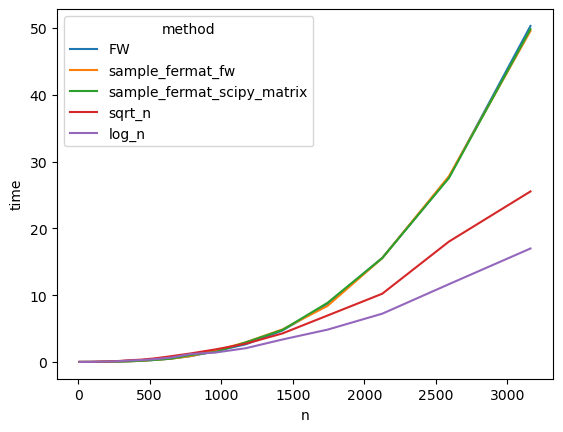

In [87]:
import seaborn as sns
sns.lineplot(x="n", y="time", hue="method", data=pd.DataFrame(results))
# plt.yscale("log")
# plt.xscale("log")

<Axes: xlabel='n', ylabel='time'>

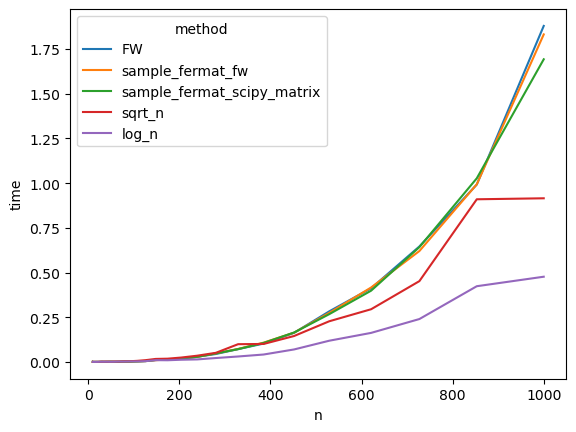

In [ ]:
import seaborn as sns
sns.lineplot(x="n", y="time", hue="method", data=pd.DataFrame(results))
# plt.yscale("log")
# plt.xscale("log")

In [90]:
df = pd.DataFrame(results)

In [112]:
alpha

1.8451665491330802

In [114]:
np.log(3162), np.sqrt(3162)

(8.058960017769417, 56.231663678038196)

In [111]:
np.nanmean(df[(df.n == 3162) & (df.method == "sqrt_n")].fdists.values[0] /
df[(df.n == 3162) & (df.method == "FW")].fdists.values[0] )

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_28728/1239168448.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean(df[(df.n == 3162) & (df.method == "sqrt_n")].fdists.values[0] /


1.1937266630048624

In [168]:
# dist_ratio_results = []
for k in [2, 3, 5, 7, 8, 9]:
    print(k)
    t0 = time()
    dists = kNN_sample_fermat(Q=X[:3162], alpha=alpha, k=int(k))
    time_taken = time() - t0
    dist_ratio_results.append({"k": k, "time": time_taken, "dists": dists})
    print(time_taken)

2
14.424252986907959
3
14.344891786575317
5
14.597304105758667
7
16.01226282119751
8
15.794023752212524
9
16.4606831073761


In [169]:
euclidean_time = time()
euclidean_dists = euclidean(X[:3162])
euclidean_time_taken = time() - euclidean_time
print(euclidean_time_taken)

2.228276014328003


In [224]:
shortest_path_time = time()
shortest_paths = shortest_path(csr_matrix(euclidean_dists), directed=False)
shortest_path_time_taken = time() - shortest_path_time
print(shortest_path_time_taken)

45.44802927970886


In [226]:
sample_fermat(X[:3162], alpha=1.83, method="scipy_matrix")

array([[      0.        ,  563087.67724184, 1453050.40196912, ...,
        1315469.91842554, 1601002.21361344,  894885.89252166],
       [ 563087.67724184,       0.        , 1678288.00273231, ...,
        1460086.12261883, 1918315.65003438,  943448.60897859],
       [1453050.40196912, 1678288.00273231,       0.        , ...,
        1784621.16267661, 2010907.78127337, 1653089.00674051],
       ...,
       [1315469.91842554, 1460086.12261883, 1784621.16267661, ...,
              0.        , 2388343.66391785,  955096.84828317],
       [1601002.21361344, 1918315.65003438, 2010907.78127337, ...,
        2388343.66391785,       0.        , 2235073.20896739],
       [ 894885.89252166,  943448.60897859, 1653089.00674051, ...,
         955096.84828317, 2235073.20896739,       0.        ]])

In [194]:
drr = pd.DataFrame(dist_ratio_results)

In [195]:
reference_dists, reference_time = df[(df.n == 3162) & (df.method == "FW")].iloc[0][["fdists", "time"]]

In [196]:
dists_desc = drr.dists.apply(lambda x: pd.Series((x / reference_dists).flatten()).describe())

In [202]:
drr = pd.concat([drr, dists_desc],axis=1).sort_values("k").reset_index(drop=True)

In [203]:
drr["rel_time"] = drr.time / reference_time

In [204]:
drr.drop(columns=["dists", "count"]).round(2).head()

,k,time,mean,std,min,25%,50%,75%,max,rel_time
0,2.0,14.42,inf,NaN,1.0,2.43,2.80,3.26,inf,0.29
1,3.0,14.34,2.16,0.42,1.0,1.87,2.11,2.38,7.05,0.29
2,5.0,14.60,1.75,0.30,1.0,1.55,1.71,1.91,5.52,0.29
3,7.0,16.01,1.60,0.26,1.0,1.43,1.56,1.73,4.89,0.32
4,8.0,15.79,1.55,0.25,1.0,1.39,1.52,1.68,4.77,0.31


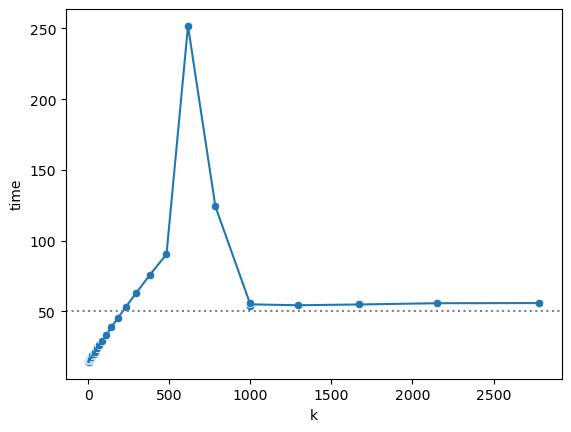

In [192]:
sns.lineplot(x="k", y="time", data=drr)
sns.scatterplot(x="k", y="time", data=drr)
plt.axhline(
    y=df[(df.n == 3162) & (df.method == "FW")].time.values[0],
    linestyle="dotted",
    color="gray",
)

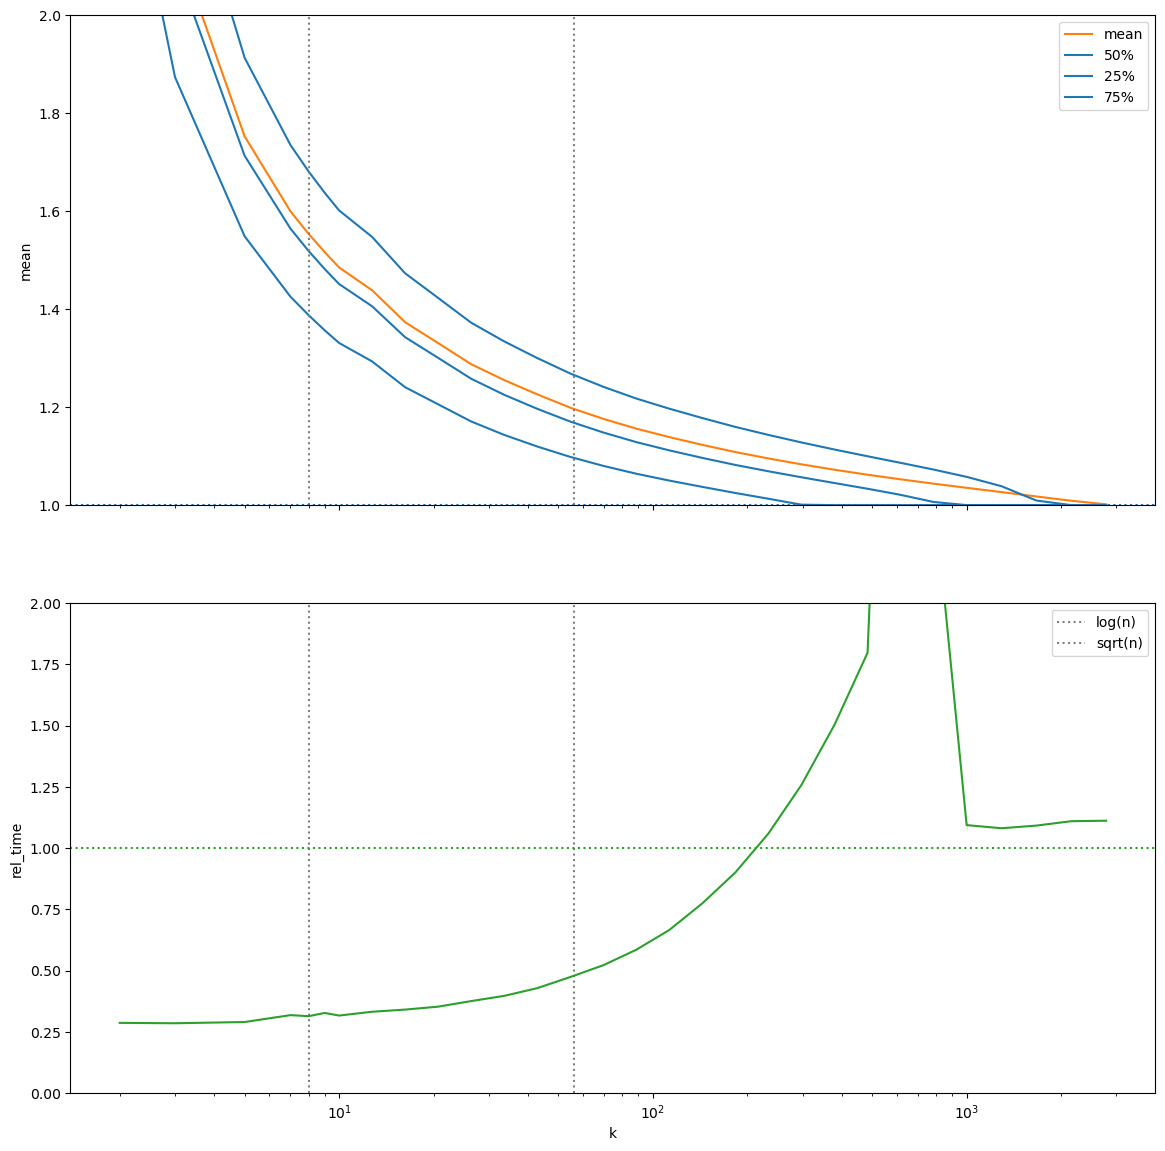

In [252]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14), sharex=True)
for col in ["mean", "50%", "25%", "75%"]:
    sns.lineplot(
        x="k", y=col, label=col, data=drr, color="C0" if col != "mean" else "C1", ax=ax1
    )
for ax in [ax1, ax2]:
    ax.axvline(x=int(np.log(3162)), linestyle="dotted", color="gray", label="log(n)")
    ax.axvline(x=int(np.sqrt(3162)), linestyle="dotted", color="gray", label="sqrt(n)")
    ax.axhline(y=1, linestyle="dotted", color="C0" if ax == ax1 else "C2")
    ax.set_xscale("log")
# ax2.axhline(y=1, linestyle="dotted", color="C2")

sns.lineplot(x="k", y="rel_time", color="C2", data=drr, ax=ax2)
ax1.set_ylim(1, 2)
ax2.set_ylim(0, 2)
plt.legend()
plt.show()

In [222]:
# k~log(n)
log_n = np.log(3162)
drr[drr.k.between(0.7*log_n, 1.3*log_n)].round(3).T.drop("dists")

,3,4,5,6
k,7.0,8.0,9.0,10.0
time,16.012,15.794,16.461,15.926
count,9995082.0,9995082.0,9995082.0,9995082.0
mean,1.6,1.553,1.516,1.485
std,0.259,0.247,0.238,0.229
min,1.0,1.0,1.0,1.0
25%,1.425,1.388,1.357,1.331
50%,1.564,1.519,1.482,1.451
75%,1.735,1.681,1.637,1.602
max,4.89,4.771,4.74,4.54


1/3 del tiempo total, pero 50% de inflación y 25% de desvío en la distancia _mediana_? No parece negocio

In [223]:
# k~sqrt(n)
sqrt_n = np.sqrt(3162)
drr[drr.k.between(0.7*sqrt_n, 1.3*sqrt_n)].round(3).T.drop("dists")

,12,13,14
k,42.813,54.556,69.519
time,21.552,23.837,26.259
count,9995082.0,9995082.0,9995082.0
mean,1.226,1.199,1.176
std,0.155,0.144,0.136
min,1.0,1.0,1.0
25%,1.12,1.098,1.08
50%,1.197,1.171,1.148
75%,1.3,1.269,1.241
max,2.726,2.532,2.386


Con $k\sim\sqrt{n},\ 20\% \pm 14\%$ de inflación, y aún tarda la mitad del tiempo. Tampoco veo negocio. ¿Será que la aproximación vale para $n$ "suficientemente grande, y ese "duficientemente son millones"?

In [288]:
df = pd.DataFrame(results)

In [307]:
FW_versus = "sqrt_n"
log_n_df = df[df.method.isin(["FW", FW_versus])].pivot(index="n", columns="method", values=["fdists", "time"])

In [308]:
log_n_df["rel_time"] = log_n_df[("time", FW_versus)] / log_n_df[("time", "FW")]
log_n_df["rel_dists"] = (log_n_df[("fdists", FW_versus)] / log_n_df[("fdists", "FW")]).apply(lambda x: np.nanmean(x.flatten()))

<Axes: xlabel='n', ylabel='rel_time'>

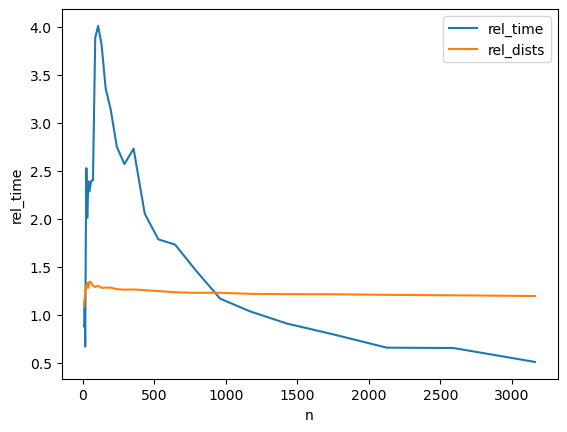

In [309]:
_data = log_n_df[["rel_time", "rel_dists"]].reset_index()
sns.lineplot(x="n", y="rel_time", data=_data, label="rel_time")
sns.lineplot(x="n", y="rel_dists", data=_data, label="rel_dists")

In [310]:
_data.round(2)

,n,rel_time,rel_dists
method,,,
0,10,0.877443,1.09
1,12,0.932747,1.15
2,14,1.14032,1.17
3,18,0.666552,1.24
4,22,1.787191,1.29
5,26,2.525361,1.27
6,32,2.007931,1.33
7,40,2.388094,1.28
8,48,2.283441,1.34


In [ ]:
dists_desc = drr.dists.apply(lambda x: pd.Series((x / reference_dists).flatten()).describe())

In [ ]:
drr = pd.concat([drr, dists_desc],axis=1).sort_values("k").reset_index(drop=True)

In [ ]:
drr["rel_time"] = drr.time / reference_time

In [ ]:
drr.drop(columns=["dists", "count"]).round(2).head()

,k,time,mean,std,min,25%,50%,75%,max,rel_time
0,2.0,14.42,inf,NaN,1.0,2.43,2.80,3.26,inf,0.29
1,3.0,14.34,2.16,0.42,1.0,1.87,2.11,2.38,7.05,0.29
2,5.0,14.60,1.75,0.30,1.0,1.55,1.71,1.91,5.52,0.29
3,7.0,16.01,1.60,0.26,1.0,1.43,1.56,1.73,4.89,0.32
4,8.0,15.79,1.55,0.25,1.0,1.39,1.52,1.68,4.77,0.31


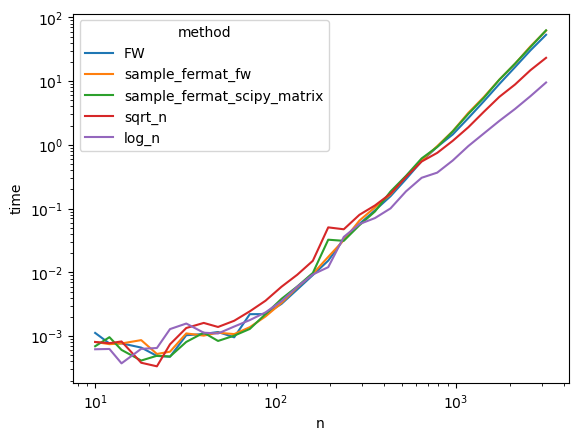

In [ ]:
import seaborn as sns
sns.lineplot(x="n", y="time", hue="method", data=pd.DataFrame(results))
plt.yscale("log")
plt.xscale("log")

<Axes: xlabel='n', ylabel='time'>

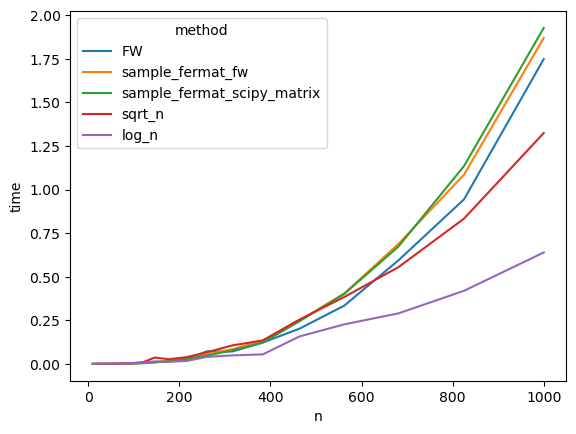

In [ ]:
import seaborn as sns
sns.lineplot(x="n", y="time", hue="method", data=pd.DataFrame(results))
plt.yscale("log")

In [ ]:
for neighbors, times in {
    "n": n_times,
    # "sqrt(n)": sqrtn_times,
    "log(n)": logn_times,
}.items():
    plt.plot(ns[: len(times)], times, label=neighbors)
plt.legend()
plt.show()

In [ ]:
n_times

In [ ]:
logn_times

In [ ]:
n_times

In [ ]:
logn_times

In [ ]:
ns = ns[: len(times)]

In [ ]:
# fit a polynomial on ns to times using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols


df = pd.DataFrame(
    {"ns": ns, "n_times": n_times, "logn_times": logn_times, "sqrtn_times": sqrtn_times}
)

In [ ]:
df.sort_values("ns")

In [ ]:
model = ols("n_times ~ 0 + I(ns**2)", data=df).fit()
model.summary()

In [ ]:
n_times_pred = model.predict({"ns": ns})
plt.plot(ns, n_times, "o")
plt.plot(ns, n_times_pred, linestyle="dotted")
# plt.xscale('log')

In [ ]:
model.predict({"ns": pd.Series(np.array([1e4, 1e5, 1e6]))}).div(3600).round(
    2
)  # in hours

24 minutos para 10K datos, 400 horas (1000, 10^3) veces más para 100K. Moi lento.

In [ ]:
df["n2logn"] = ns**2 * np.log(ns)

In [ ]:
model = ols("logn_times ~ 0 + I(ns**2)", data=df).fit()
model.summary()

In [ ]:
logn_times_pred = model.predict({"ns": ns})
plt.plot(ns, logn_times, "o")
plt.plot(ns, logn_times_pred, linestyle="dotted")
# plt.xscale('log')

In [ ]:
model.predict({"ns": pd.Series(np.array([1e4, 1e5, 1e6]))}).div(3600).round(
    2
)  # in hours

Igual estamos en _una hora_ de cómputo para 100K datos. jodido.

In [ ]:
N = 2000
dists = euclidean(X[:N])

In [ ]:
dists.round(2)

In [ ]:
import numpy as np
from scipy.spatial import Delaunay

tri = Delaunay(X[:1000])

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(X[:N], metric="euclidean")

In [ ]:
N = dists.shape[0]
# k = np.ceil(np.log(N)).astype(int)  #log(N)-NN weighted graph
k = np.ceil(np.sqrt(N)).astype(int)  # sqrt(N)-NN weighted graph

In [ ]:
from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path


def kNN_sample_fermat(Q, alpha, k):
    N = Q.shape[0]
    tree = KDTree(Q, metric="euclidean")
    nearest_distances, nearest_indices = tree.query(Q, k=k + 1)
    indptr = np.arange(0, N * (k + 1) + 1, k + 1)
    indices = nearest_indices.flatten()
    data = nearest_distances.flatten()
    kNN = csr_matrix((data**alpha, indices, indptr))
    return shortest_path(csgraph=kNN, directed=False)

In [ ]:
indptr = np.arange(0, N * (k + 1) + 1, k + 1)
indices = nearest_indices.flatten()
data = nearest_distances.flatten()
kNN = csr_matrix((data, indices, indptr))

In [ ]:
kNN

In [ ]:
nearest_distances, nearest_indices = tree.query(X, k=k + 1)

indptr = np.arange(0, N * (k + 1) + 1, k + 1)
indices = nearest_indices.flatten()
data = nearest_distances.flatten()
sqrtkNN = csr_matrix((data, indices, indptr))

In [ ]:
sqrtkNN

In [ ]:
%%timeit
NNdist = shortest_path(csgraph=kNN, directed=False)

In [ ]:
%%timeit
sqrtNNdist = shortest_path(csgraph=sqrtkNN, directed=False)

In [ ]:
%%timeit
Cdist = shortest_path(dists, directed=False)

In [ ]:
sqrtNNdist = shortest_path(csgraph=sqrtkNN, directed=False)

In [ ]:
NNdist = shortest_path(csgraph=kNN, directed=False)
Cdist = shortest_path(dists, directed=False)

In [ ]:
np.nanmean(NNdist / Cdist)

In [ ]:
np.nanmean(sqrtNNdist / Cdist)

In [ ]:
k = 3
np.array(
    [np.where(dists[i] <= kth_dist[i], dists[i], np.nan) for i in range(dists.shape[0])]
).round(2)

In [ ]:
dists[i][dists[i] <= kth_dist[i]]

In [ ]:
# create csr matrix
from scipy.sparse import csr_matrix

In [ ]:
# keep only the K smallest entries of each row of dists
K = 3
dists = np.sort(dists, axis=1)[:, :K]

In [ ]:
# Calculate the fermat distance matrix using plain numpy/scipy methods
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

In [ ]:
methods = ["fw", "networkx", "scipy_matrix", "scipy_array"]
for m1 in methods:
    for m2 in methods:
        assert np.allclose(
            sample_fermat(X, alpha=alpha, method=m1),
            sample_fermat(X, alpha=alpha, method=m2),
        )

In [ ]:
%%timeit
sample_fermat(X, alpha=alpha, method="fermat")

In [ ]:
%%timeit
sample_fermat(X, alpha=alpha, method="networkx")

In [ ]:
%%timeit
sample_fermat(X, alpha=alpha, method="scipy_matrix")

In [ ]:
%%timeit
sample_fermat(X, alpha=alpha, method="scipy_array")

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
X.shape

In [ ]:
%%timeit
sample_fermat(X, alpha=alpha, method="scipy_array")

In [ ]:
Dfermat_nx(X, alpha)[:5, :5]

In [ ]:
def Dfermat_scipy(Q, alpharawfermat = shortest_path(
    csgraph=np.power(euclidean(X), alpha),
    method='FW',
    directed=False
)[:5, :5]

## Test de performance: fermat.Fermat.get_distances vs. calculo directo en el grafo
 

In [ ]:
class OOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities

In [ ]:
from joblib import Memory
import numbers
from sklearn.base import BaseEstimator, DensityMixin

cachedir = "_cache"
memory = Memory(cachedir, verbose=0)


@memory.cache
def _get_micro_fermat_dists(Q, alpha):
    return Fermat(alpha=alpha, path_method="FW").fit(euclidean(Q)).get_distances()


class FermatKDE(BaseEstimator, DensityMixin):
    def __init__(self, bandwidth=1, alpha=1, d=None):
        self.bandwidth = bandwidth
        self.alpha = alpha
        self.d = d

    def fit(self, X):
        self.Q_ = X
        # A is the adjacency matrix with Fermat distances as edge weights
        self.A_ = _get_micro_fermat_dists(X, self.alpha)
        if self.d is None:
            self.d = self.D
        return self

    @property
    def N(self):
        return self.Q_.shape[0]

    @property
    def D(self):
        return self.Q_.shape[1]

    def _sample_distances(self, X):
        to_Q = cdist(X, self.Q_) ** self.alpha
        sample_distances = np.zeros((X.shape[0], self.N))
        for i in range(len(X)):
            sample_distances[i, :] = np.min(to_Q[i].T + self.A_, axis=1)
        return sample_distances

    def score_samples(self, X=None, log=True):
        if X is None:
            X = self.Q_

        densities = (
            (self.bandwidth**-self.d)
            * (2 * np.pi) ** (-self.d / 2)
            * np.exp(self._sample_distances(X) / self.bandwidth) ** 2
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def score(self, X=None):
        if X is None:
            X = self.Q_
        return self.score_samples(X).sum()

In [ ]:
fkde = FermatKDE(alpha=1.23, bandwidth=0.1).fit(X)

In [ ]:
oosfkde._distances(X)

In [ ]:
oosfkde = OOSFermatKDE(alpha=1.23, bandwidth=0.1).fit(X)
oosfkde.density(X).sum()

In [ ]:
assert np.allclose()fkde._sample_distances(X), oosfkde._distances(X)

In [ ]:
fkde.score_samples(X)

In [ ]:
assert np.all(fkde.score_samples(X) == fkde.score_samples())

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# load boston dataset
from sklearn.datasets import load_iris

X = load_iris().data

In [ ]:
X, y = X[:, :3], X[:, 3]

In [ ]:
lr = LinearRegression().fit(X, y)

In [ ]:
dir(lr)

In [ ]:
from joblib import Memory
from sklearn.base import BaseEstimator

cachedir = "_cache"
memory = Memory(cachedir, verbose=0)


@memory.cache
def _get_micro_fermat_dists(Q, alpha):
    return Fermat(alpha=alpha, path_method="FW").fit(euclidean(Q)).get_distances()


class FemtoKDE(BaseEstimator):
    def __init__(self, bandwidth=1, alpha=1):
        self.bandwidth = bandwidth
        self.alpha = alpha

    def fit(self, X):
        self.Q = X
        # A is the adjacency matrix with Fermat distances as edge weights
        self.A = _get_micro_fermat_dists(self.Q, self.alpha)

    @property
    def N(self):
        return self.Q.shape[0]

    @property
    def D(self):
        return self.Q.shape[1]

    def __call__(self, X, Y=None):
        if X.ndim > 2:
            raise ValueError("X must be a 1D or 2D array")
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if Y is None:
            to_Q = cdist(X, self.Q) ** self.alpha
            return np.min(to_Q.T + self.A, axis=1)
        elif Y.ndim > 2:
            raise ValueError("Y must be a 1D or 2D array")
        elif Y.ndim == 1:
            Y = Y.reshape(1, -1)
        straight_dist = cdist(X, Y) ** self.alpha
        X_to_Q = cdist(X, self.Q) ** self.alpha
        Q_to_Y = cdist(self.Q, Y) ** self.alpha
        through_dist = np.empty((X.shape[0], Y.shape[0]))
        for ix, x_to_Q in enumerate(X_to_Q):
            for iy, Q_to_y in enumerate(Q_to_Y):
                through_dist[ix, iy] = np.min(x_to_Q + self.A + Q_to_y.T)
        return np.minimum(straight_dist, through_dist)

In [ ]:
microfd = MicroFermatDist(X)

In [ ]:
def find_row_index(X, y):
    rows_equal = np.all(X == y, axis=1)
    return np.argmax(rows_equal) if np.any(rows_equal) else -1

In [ ]:
# Create 10K x 10K random matrix
XL = np.random.rand(10000, 1000)

In [ ]:
microfd(X)

In [ ]:
cdist([X[0] + 0.1], X)

In [ ]:
microfd(X[0] + 0.1)

In [ ]:
%%timeit
Fermat(alpha=1, path_method="FW").fit(euclidean(X)).get_distances()

In [ ]:
%%timeit
MicroFermatDist(X)

In [ ]:
from time import time

t0 = time()
for i in range(10):
    Fermat(alpha=1, path_method="FW").fit(euclidean(X)).get_distances()
print(time() - t0)

In [ ]:
from time import time

t0 = time()
for i in range(10):
    MicroFermatDist(X, alpha=1).A
print(time() - t0)

In [ ]:
from time import time

t0 = time()
for i in range(10):
    MicroFermatDist(X, alpha=i + 1).A
print(time() - t0)

In [ ]:
FERMAT_CACHE = {}


def fermat_distances(alpha, X, cache=FERMAT_CACHE):
    return cache.setdefault(
        (alpha, hash(ndarray_to_tuple(X))),
        Fermat(alpha=alpha, path_method="FW").fit(euclidean(X)).get_distances(),
    )

In [ ]:
# import sleep
from time import sleep
from functools import lru_cache

In [ ]:
# @lru_cache()
class Sleepy:
    def __init__(self, **kwargs):
        sleep(2)
        for kwarg, val in kwargs.items():
            setattr(self, kwarg, val)

In [ ]:
s = Sleepy(a=[1, 2], b=2, c=3)

In [ ]:
s = Sleepy(a=1, b=2, c=3)

In [ ]:
fermat_distances(1, load_iris().data)

In [ ]:
fermat_distances(1, load_iris().data)

In [ ]:
import collections.abc
import numbers
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator


class FermatKDE(BaseEstimator):
    def __init__(self, alpha=1, bandwidth=1, fermat_cache=None):
        print(bandwidth)
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X, y=None):
        self.X_ = X
        self.pdists_ = pdist(X, metric="euclidean")
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            squareform(self.pdists_)
        )
        self.n_, self.dim_ = X.shape

        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        dists_to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, dist_to_edge in enumerate(dists_to_edge):
            dists[i, :] = np.min(dist_to_edge.T + self.fermat_.get_distances(), axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities

    def score_samples(self, X, y=None):
        return self.density(X, log=True)

    def score(self, X, y=None):
        return self.score_samples(X).sum()

In [ ]:
class FermatKDE(BaseEstimator):
    def __init__(self, alpha=1, bandwidth=None):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X, y=None):
        self.X_ = X

        h = self.bandwidth
        # self.h_ = h
        self.h_ = None
        if isinstance(h, numbers.Number):
            self.h_ = h
            print("h is number")
        elif isinstance(h, collections.abc.Sequence) and all(
            isinstance(i, numbers.Number) for i in h
        ):
            h_grid = np.array(h)
            print("h is sequence")
        elif h == "auto":
            print("auto h")
            iqr = np.percentile(self.pdists_, 75) - np.percentile(self.pdists_, 25)
            h_pilot = 0.9 * min(self.pdists_.std(), iqr / 1.34) * self.n_ ** (-1 / 5)
            h_grid = np.logspace(-1, 0.5, 10) * h_pilot  # ~[0.1, 3] * pilot
            print(h_grid)
            # h_grid = self.pdists_.mean() + np.linspace(-2, 2, 9) * self.pdists_.std()
        else:
            raise NotImplementedError
        if self.h_ is None:
            cross_val = GridSearchCV(
                self, {"bandwidth": h_grid}, scoring="neg_log_loss", cv=5, n_jobs=-1
            ).fit(X)
            self.h_ = cross_val.best_params_["bandwidth"]
            self.cross_val_ = cross_val

In [ ]:
8 + np.linspace(-2, 2, 9) * 2

In [ ]:
seed = 0
X_train, X_test = train_test_split(X, test_size=4 / 5, random_state=seed)
idx_train, idx_test = train_test_split(
    np.arange(len(X)), test_size=4 / 5, random_state=seed
)
# Choosing train/test split by indices is equivalent to choosing rows themselves
assert np.all(X_train == X[idx_train])

In [ ]:
fkde = FermatKDE(alpha=1, bandwidth=1.23).fit(X)
oosfkde = OOSFermatKDE(alpha=1, bandwidth=1.23).fit(X)

In [ ]:
assert np.all(fkde.fermat_.get_distances() == oosfkde.fermat_dists_)

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_splits = 5
ss = ShuffleSplit(n_splits, test_size=1 - 1 / n_splits, random_state=12)
# for train_index, test_index in ss.split(X):
# print("%s %s" % (train_index, test_index))

In [ ]:
hs = np.logspace(-5, 0, 50)
kfolds = GridSearchCV(FermatKDE(), {"bandwidth": hs}, cv=splits, n_jobs=-1).fit(X_train)

In [ ]:
shuffle = GridSearchCV(FermatKDE(), {"bandwidth": hs}, cv=ss, n_jobs=-1).fit(X_train)

In [ ]:
kfolds.best_params_, shuffle.best_params_

In [ ]:
kfolds.best_estimator_.fit(X_train).score(X_test), shuffle.best_estimator_.fit(
    X_train
).score(X_test)

In [ ]:
res = {}
for h in hs:
    est = FermatKDE(bandwidth=h).fit(X_train)
    score = est.score(X_train)
    res[h] = score

In [ ]:
best_h = pd.Series(res).idxmax()
best_h, pd.Series(res)[best_h]

In [ ]:
res = {}
for h in hs:
    est = FermatKDE(bandwidth=h).fit(X_train)
    score = est.score(X_test)
    res[h] = score

In [ ]:
best_h = pd.Series(res).idxmax()
best_h, pd.Series(res)[best_h]

In [ ]:
len(X_train)

In [ ]:
cv1 = GridSearchCV(
    FermatKDE(), {"bandwidth": hs}, cv=[(idx_train, idx_test)], n_jobs=-1
).fit(X)

In [ ]:
cv1.best_params_, cv1.best_score_

In [ ]:
120 / 5

In [ ]:
exploration = pd.DataFrame(
    dict(
        n_train=[96, 24, 120],
        score=[-230.23993352118526, -301.53378712804954, -222.4954305828442],
        h_opt=[0.09540954763499944, 0.15264179671752334, 0.07543120063354623],
    )
)

In [ ]:
exploration

In [ ]:
plt.plot(exploration.n_train, exploration.h_opt, "o-")

In [ ]:
cv1.best_estimator_.fit(X_train).score(X_test)

In [ ]:
cv1.best_params_, cv1.best_score_

In [ ]:
# Strings are sequences!
assert isinstance("asdasd", collections.abc.Sequence)

In [ ]:
FermatKDE(alpha=1, bandwidth="auto").fit(X_train).h_

In [ ]:
fkde = FermatKDE(alpha=1, bandwidth=0.07).fit(X)
fkde.score(X)

In [ ]:
oosfkde = OOSFermatKDE(alpha=1, bandwidth=0.07).fit(X)

In [ ]:
oosfkde.density(X).sum()

In [ ]:
dists = pdist(X, metric="euclidean")
dists.mean(), dists.std()
pd.Series(dists).describe()

In [ ]:
iqr = np.percentile(dists, 75) - np.percentile(dists, 25)
h_pilot = 0.9 * min(dists.std(), iqr / 1.34) * len(X) ** (-1 / 5)
h_pilot

In [ ]:
KernelDensity(bandwidth=h_pilot).fit(X).score(X)

In [ ]:
from sklearn import KernelDensity

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

kde = KernelDensity(kernel="gaussian", bandwidth=0.1).fit(X)

In [ ]:
len(X) ** -0.2

In [ ]:
cvfkde.best_params_

In [ ]:
plt.plot(np.linspace(0.01, 0.2, 20), cvfkde.cv_results_["mean_test_score"])

In [ ]:
plt.plot(cvfkde.cv_results_["param_bandwidth"], -cvfkde.cv_results_["mean_test_score"])

In [ ]:
import sklearn as sk

sk.metrics.get_scorer_names()

In [ ]:
# get upper triangular half of fermat_dists_
fermat_dists = fkde.fermat_dists_
fermat_dists[np.tril_indices_from(fermat_dists)] = np.nan
plt.imshow(fermat_dists)

In [ ]:
fkde.fermat_dists_.sum(), fermat_dists.sum()

## Bootstrap - choose w/ repetition

In [ ]:
# write a function that chooses K integers between 0 and N-1, with repetition
def choose_k(N, K):
    return np.random.randint(0, N, size=K)


N = 5000000
pd.Series(choose_k(N, N)).value_counts().reindex_like(pd.Series(range(N))).fillna(
    0
).astype(int).value_counts().div(N).plot(kind="bar")
# plt.yscale("log")
plt.show()